# AutoML Image Classification: Added Noise (Digits)

![](imgs/gaussian_noise.png)

In [1]:
import random as rn
from abc import ABC, abstractmethod

import h2o
import matplotlib.pyplot as plt
import numpy as np
from h2o.automl import H2OAutoML
from numpy.random import RandomState
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from tpot import TPOTClassifier

from dpemu import runner
from dpemu.filters.common import GaussianNoise, Clip
from dpemu.nodes import Array
from dpemu.nodes.series import Series
from dpemu.plotting_utils import visualize_scores, print_results_by_model

In [2]:
def get_data():
    random_state = RandomState(42)
    digits = load_digits()
    return train_test_split(digits["data"], digits["target"], test_size=.2, random_state=random_state)

In [3]:
def get_err_root_node():
    err_img_node = Array(reshape=(8, 8))
    err_root_node = Series(err_img_node)
    err_img_node.addfilter(GaussianNoise("mean", "std"))
    err_img_node.addfilter(Clip("min_val", "max_val"))
    return err_root_node

In [4]:
def get_err_params_list(data):
    min_val = np.amin(data)
    max_val = np.amax(data)
    std_steps = np.round(np.linspace(0, max_val, num=8), 3)
    err_params_list = [{"mean": 0, "std": std, "min_val": min_val, "max_val": max_val} for std in std_steps]
    return err_params_list

In [5]:
class Preprocessor:

    def run(self, train_data, test_data, params):
        return train_data, test_data, {}

In [6]:
class AbstractModel(ABC):

    def __init__(self):
        self.seed = 42
        self.random_state = RandomState(self.seed)

    @abstractmethod
    def get_fitted_model(self, train_data, train_labels, params):
        pass

    @abstractmethod
    def get_accuracy(self, data, labels, fitted_model, params):
        pass

    @abstractmethod
    def get_best_pipeline(self, fitted_model):
        pass

    def run(self, train_data, test_data, params):
        train_labels = params["train_labels"]
        test_labels = params["test_labels"]

        fitted_model = self.get_fitted_model(train_data, train_labels, params)

        return {
            "test_accuracy": self.get_accuracy(test_data, test_labels, fitted_model, params),
            "train_accuracy": self.get_accuracy(train_data, train_labels, fitted_model, params),
            "best_pipeline": self.get_best_pipeline(fitted_model),
        }

class TPOTClassifierModel(AbstractModel):

    def __init__(self):
        super().__init__()

    def get_fitted_model(self, train_data, train_labels, params):
        return TPOTClassifier(
            generations=5,
            population_size=50,
            n_jobs=-1,
            random_state=self.seed,
            verbosity=0,
        ).fit(train_data, train_labels)
    
    def get_accuracy(self, data, labels, fitted_model, params):
        return round(fitted_model.score(data, labels), 3)

    def get_best_pipeline(self, fitted_model):
        return [step[0] for step in fitted_model.fitted_pipeline_.steps]

class H2OAutoMLModel(AbstractModel):

    def __init__(self):
        super().__init__()
        h2o.init(name=f"#{rn.SystemRandom().randint(1, 2**30)}")
        h2o.no_progress()

    def get_fitted_model(self, train_data, train_labels, params):
        train_data = h2o.H2OFrame(np.concatenate((train_data, train_labels.reshape(-1, 1)), axis=1))
        x = np.array(train_data.columns)[:-1].tolist()
        y = np.array(train_data.columns)[-1].tolist()
        train_data[y] = train_data[y].asfactor()
        aml = H2OAutoML(max_models=20, seed=self.seed)
        aml.train(x=x, y=y, training_frame=train_data)
        return aml

    def get_accuracy(self, data, labels, fitted_model, params):
        data = h2o.H2OFrame(np.concatenate((data, labels.reshape(-1, 1)), axis=1))
        y = np.array(data.columns)[-1].tolist()
        data[y] = data[y].asfactor()
        pred = fitted_model.predict(data).as_data_frame(header=False)["predict"].values.astype(int)
        return np.round(np.mean(pred == labels), 3)

    def get_best_pipeline(self, fitted_model):
        leader_params = fitted_model.leader.get_params()
        best_pipeline = [leader_params["model_id"]["actual_value"]["name"]]
        if "base_models" in leader_params:
            for base_model in leader_params["base_models"]["actual_value"]:
                best_pipeline.append(base_model["name"])
        h2o.cluster().shutdown()
        return best_pipeline

In [7]:
def get_model_params_dict_list(train_labels, test_labels):
    model_params_base = {"train_labels": train_labels, "test_labels": test_labels}
    return [
        {
            "model": TPOTClassifierModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": False
        },
        {
            "model": TPOTClassifierModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": True
        },
        {
            "model": H2OAutoMLModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": False
        },
        {
            "model": H2OAutoMLModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": True
        },
    ]

In [8]:
def visualize(df):
    visualize_scores(
        df,
        score_names=["test_accuracy", "train_accuracy"],
        is_higher_score_better=[True, True],
        err_param_name="std",
        title="Classification scores with added error"
    )
    plt.show()

In [9]:
def main():
    train_data, test_data, train_labels, test_labels = get_data()

    df = runner.run(
        train_data=train_data,
        test_data=test_data,
        preproc=Preprocessor,
        preproc_params=None,
        err_root_node=get_err_root_node(),
        err_params_list=get_err_params_list(train_data),
        model_params_dict_list=get_model_params_dict_list(train_labels, test_labels),
    )

    print_results_by_model(df, [
        "mean", 
        "min_val", 
        "max_val", 
        "train_labels", 
        "test_labels"
    ])
    visualize(df)

  0%|          | 0/8 [00:00<?, ?it/s]

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu/venv/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpqyihf7lm

  JVM stdout: /wrk/users/thalvari/tmpqyihf7lm/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpqyihf7lm/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,04 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.6
H2O cluster version age:,3 days
H2O cluster name:,#766587653
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu/venv/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmppz79mrtc

  JVM stdout: /wrk/users/thalvari/tmppz79mrtc/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmppz79mrtc/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54323

Connecting to H2O server at http://127.0.0.1:54323 ..

.

 successful.

H2O cluster uptime:,06 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.6
H2O cluster version age:,3 days
H2O cluster name:,#525636491
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu/venv/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpq1nck4te

  JVM stdout: /wrk/users/thalvari/tmpq1nck4te/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpq1nck4te/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54329

Connecting to H2O server at http://127.0.0.1:54329 ..

.

 successful.

H2O cluster uptime:,05 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.6
H2O cluster version age:,3 days
H2O cluster name:,#851864927
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu/venv/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpy61vzunr

  JVM stdout: /wrk/users/thalvari/tmpy61vzunr/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpy61vzunr/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54333

Connecting to H2O server at http://127.0.0.1:54333 ..

.

 successful.

H2O cluster uptime:,08 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.6
H2O cluster version age:,3 days
H2O cluster name:,#815433463
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu/venv/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpgc52t7y5

  JVM stdout: /wrk/users/thalvari/tmpgc52t7y5/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpgc52t7y5/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54335

Connecting to H2O server at http://127.0.0.1:54335 ..

.

.

 successful.

H2O cluster uptime:,20 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.6
H2O cluster version age:,3 days
H2O cluster name:,#1066381914
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu/venv/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmp171orz3r

  JVM stdout: /wrk/users/thalvari/tmp171orz3r/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmp171orz3r/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54339

Connecting to H2O server at http://127.0.0.1:54339 ..

.

 successful.

H2O cluster uptime:,19 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.6
H2O cluster version age:,3 days
H2O cluster name:,#242881262
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu/venv/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpl7t5tn0j

  JVM stdout: /wrk/users/thalvari/tmpl7t5tn0j/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpl7t5tn0j/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54343

Connecting to H2O server at http://127.0.0.1:54343 ..

.

 successful.

H2O cluster uptime:,20 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.6
H2O cluster version age:,3 days
H2O cluster name:,#55723038
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


H2O session _sid_af6d closed.

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu/venv/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpfk2zggab

  JVM stdout: /wrk/users/thalvari/tmpfk2zggab/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpfk2zggab/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,15 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.6
H2O cluster version age:,3 days
H2O cluster name:,#253974962
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_bc00 closed.

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu/venv/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmponrcjuft

  JVM stdout: /wrk/users/thalvari/tmponrcjuft/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmponrcjuft/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54323

Connecting to H2O server at http://127.0.0.1:54323 ..

.

 successful.

H2O cluster uptime:,19 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.6
H2O cluster version age:,3 days
H2O cluster name:,#840211565
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu/venv/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpv4dh7t82

  JVM stdout: /wrk/users/thalvari/tmpv4dh7t82/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpv4dh7t82/h2o_thalvari_started_from_python.err

H2O session _sid_b671 closed.

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu/venv/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpbvj23gu5

  JVM stdout: /wrk/users/thalvari/tmpbvj23gu5/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpbvj23gu5/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54347

Connecting to H2O server at http://127.0.0.1:54347 ..

.

 successful.

H2O cluster uptime:,19 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.6
H2O cluster version age:,3 days
H2O cluster name:,#591147185
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


  Server is running at http://127.0.0.1:54329

Connecting to H2O server at http://127.0.0.1:54329 ..

.

 successful.

H2O cluster uptime:,20 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.6
H2O cluster version age:,3 days
H2O cluster name:,#942735652
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


H2O session _sid_afb4 closed.

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu/venv/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpwhmmh7bj

  JVM stdout: /wrk/users/thalvari/tmpwhmmh7bj/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpwhmmh7bj/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54337

Connecting to H2O server at http://127.0.0.1:54337 ..

.

 successful.

H2O cluster uptime:,23 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.6
H2O cluster version age:,3 days
H2O cluster name:,#516706825
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


H2O session _sid_8aa8 closed.

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu/venv/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmp5xfl4u48

  JVM stdout: /wrk/users/thalvari/tmp5xfl4u48/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmp5xfl4u48/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54339

Connecting to H2O server at http://127.0.0.1:54339 ..

.

 successful.

H2O cluster uptime:,24 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.6
H2O cluster version age:,3 days
H2O cluster name:,#28451857
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


H2O session _sid_92c0 closed.

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu/venv/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmp97g8kzlb

  JVM stdout: /wrk/users/thalvari/tmp97g8kzlb/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmp97g8kzlb/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54335

Connecting to H2O server at http://127.0.0.1:54335 ..

.

 successful.

H2O cluster uptime:,24 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.6
H2O cluster version age:,3 days
H2O cluster name:,#61086523
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


H2O session _sid_be9b closed.

H2O session _sid_8edf closed.

H2O session _sid_8aa9 closed.

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu/venv/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpym7tetcn

  JVM stdout: /wrk/users/thalvari/tmpym7tetcn/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpym7tetcn/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,12 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.6
H2O cluster version age:,3 days
H2O cluster name:,#622304426
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_8a63 closed.

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu/venv/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpni173jdm

  JVM stdout: /wrk/users/thalvari/tmpni173jdm/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpni173jdm/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54327

Connecting to H2O server at http://127.0.0.1:54327 ..

.

 successful.

H2O cluster uptime:,11 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.6
H2O cluster version age:,3 days
H2O cluster name:,#1008132932
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_9395 closed.

H2O session _sid_a457 closed.

H2O session _sid_b92d closed.

H2O session _sid_aec6 closed.

H2O session _sid_822e closed.

H2O session _sid_836c closed.

 12%|█▎        | 1/8 [2:39:59<18:39:53, 9599.13s/it]

100%|██████████| 8/8 [2:39:59<00:00, 1199.89s/it]   

'H2OAutoML #1'

,test_accuracy,train_accuracy,best_pipeline,std,time_err,time_pre,time_mod
0,0.983,1.000,"[StackedEnsemble_AllModels_AutoML_20191005_203524, GBM_2_AutoML_20191005_203524, GBM_3_AutoML_20191005_203524, GBM_5_AutoML_20191005_203524, DeepLearning_grid_1_AutoML_20191005_203524_model_1, GBM_grid_1_AutoML_20191005_203524_model_2, GBM_4_AutoML_20191005_203524, XGBoost_grid_1_AutoML_20191005_203524_model_4, XGBoost_grid_1_AutoML_20191005_203524_model_1, XRT_1_AutoML_20191005_203524, GLM_grid_1_AutoML_20191005_203524_model_1, GBM_1_AutoML_20191005_203524, DRF_1_AutoML_20191005_203524, DeepLearning_grid_1_AutoML_20191005_203524_model_2, XGBoost_3_AutoML_20191005_203524, XGBoost_1_AutoML_20191005_203524, XGBoost_grid_1_AutoML_20191005_203524_model_3, XGBoost_2_AutoML_20191005_203524, XGBoost_grid_1_AutoML_20191005_203524_model_2, DeepLearning_1_AutoML_20191005_203524, GBM_grid_1_AutoML_20191005_203524_model_1]",0.000,0.174,0.0,2392.076
1,0.967,1.000,"[StackedEnsemble_AllModels_AutoML_20191005_201605, GBM_2_AutoML_20191005_201605, GBM_3_AutoML_20191005_201605, GBM_4_AutoML_20191005_201605, GBM_5_AutoML_20191005_201605, XGBoost_1_AutoML_20191005_201605, DeepLearning_grid_1_AutoML_20191005_201605_model_1, DRF_1_AutoML_20191005_201605, XGBoost_3_AutoML_20191005_201605, GLM_grid_1_AutoML_20191005_201605_model_1, XGBoost_grid_1_AutoML_20191005_201605_model_4, GBM_1_AutoML_20191005_201605, XGBoost_grid_1_AutoML_20191005_201605_model_1, GBM_grid_1_AutoML_20191005_201605_model_2, XRT_1_AutoML_20191005_201605, DeepLearning_grid_1_AutoML_20191005_201605_model_2, XGBoost_2_AutoML_20191005_201605, XGBoost_grid_1_AutoML_20191005_201605_model_3, XGBoost_grid_1_AutoML_20191005_201605_model_2, DeepLearning_1_AutoML_20191005_201605, GBM_grid_1_AutoML_20191005_201605_model_1]",2.286,0.195,0.0,2877.157
2,0.922,1.000,"[StackedEnsemble_AllModels_AutoML_20191005_200306, DeepLearning_grid_1_AutoML_20191005_200306_model_1, GLM_grid_1_AutoML_20191005_200306_model_1, XGBoost_1_AutoML_20191005_200306, DeepLearning_grid_1_AutoML_20191005_200306_model_2, GBM_3_AutoML_20191005_200306, DRF_1_AutoML_20191005_200306, GBM_4_AutoML_20191005_200306, XGBoost_grid_1_AutoML_20191005_200306_model_4, GBM_2_AutoML_20191005_200306, GBM_5_AutoML_20191005_200306, GBM_grid_1_AutoML_20191005_200306_model_2, XGBoost_3_AutoML_20191005_200306, XRT_1_AutoML_20191005_200306, GBM_1_AutoML_20191005_200306, XGBoost_grid_1_AutoML_20191005_200306_model_1, XGBoost_2_AutoML_20191005_200306, XGBoost_grid_1_AutoML_20191005_200306_model_3, XGBoost_grid_1_AutoML_20191005_200306_model_2, DeepLearning_1_AutoML_20191005_200306, GBM_grid_1_AutoML_20191005_200306_model_1]",4.571,0.198,0.0,2755.898
3,0.792,0.999,"[StackedEnsemble_AllModels_AutoML_20191005_194732, XGBoost_1_AutoML_20191005_194732, GLM_grid_1_AutoML_20191005_194732_model_1, DeepLearning_grid_1_AutoML_20191005_194732_model_2, XGBoost_grid_1_AutoML_20191005_194732_model_4, DeepLearning_grid_1_AutoML_20191005_194732_model_1, XRT_1_AutoML_20191005_194732, GBM_5_AutoML_20191005_194732, XGBoost_2_AutoML_20191005_194732, GBM_2_AutoML_20191005_194732, XGBoost_3_AutoML_20191005_194732, GBM_3_AutoML_20191005_194732, GBM_4_AutoML_20191005_194732, DRF_1_AutoML_20191005_194732, XGBoost_grid_1_AutoML_20191005_194732_model_3, XGBoost_grid_1_AutoML_20191005_194732_model_1, GBM_1_AutoML_20191005_194732, GBM_grid_1_AutoML_20191005_194732_model_2, XGBoost_grid_1_AutoML_20191005_194732_model_2, GBM_grid_1_AutoML_20191005_194732_model_1, DeepLearning_1_AutoML_20191005_194732]",6.857,0.184,0.0,2146.534
4,0.636,0.991,"[StackedEnsemble_AllModels_AutoML_20191005_200007, GLM_grid_1_AutoML_20191005_200007_model_1, DeepLearning_grid_1_AutoML_20191005_200007_model_2, XGBoost_1_AutoML_20191005_200007, XGBoost_grid_1_AutoML_20191005_200007_model_4, XGBoost_2_AutoML_20191005_200007, XGBoost_3_AutoML_20191005_200007, DeepLearning_grid_1_AutoML_20191005_200007_model_1, GBM_5_AutoML_20191005_200007, XGBoost_grid_1_AutoML_20191005_200007_model_3, GBM_4_AutoML_20191005_200007, 

'H2OAutoMLClean #1'

,test_accuracy,train_accuracy,best_pipeline,std,time_err,time_pre,time_mod
0,0.983,1.0,"[StackedEnsemble_AllModels_AutoML_20191005_211459, DeepLearning_grid_1_AutoML_20191005_211459_model_1, GBM_2_AutoML_20191005_211459, DeepLearning_grid_1_AutoML_20191005_211459_model_2, GBM_3_AutoML_20191005_211459, GBM_5_AutoML_20191005_211459, GBM_grid_1_AutoML_20191005_211459_model_2, GBM_4_AutoML_20191005_211459, XGBoost_grid_1_AutoML_20191005_211459_model_4, XGBoost_grid_1_AutoML_20191005_211459_model_1, GLM_grid_1_AutoML_20191005_211459_model_1, XRT_1_AutoML_20191005_211459, GBM_1_AutoML_20191005_211459, DRF_1_AutoML_20191005_211459, XGBoost_3_AutoML_20191005_211459, XGBoost_1_AutoML_20191005_211459, XGBoost_grid_1_AutoML_20191005_211459_model_3, XGBoost_2_AutoML_20191005_211459, XGBoost_grid_1_AutoML_20191005_211459_model_2, DeepLearning_1_AutoML_20191005_211459, GBM_grid_1_AutoML_20191005_211459_model_1]",0.000,0.174,0.0,1397.170
1,0.861,1.0,"[StackedEnsemble_BestOfFamily_AutoML_20191005_210344, GBM_2_AutoML_20191005_210344, DeepLearning_grid_1_AutoML_20191005_210344_model_1, XGBoost_grid_1_AutoML_20191005_210344_model_4, GLM_grid_1_AutoML_20191005_210344_model_1, XRT_1_AutoML_20191005_210344, DRF_1_AutoML_20191005_210344]",2.286,0.195,0.0,1805.900
2,0.789,1.0,"[StackedEnsemble_AllModels_AutoML_20191005_204913, GBM_2_AutoML_20191005_204913, GBM_3_AutoML_20191005_204913, DeepLearning_grid_1_AutoML_20191005_204913_model_1, GBM_5_AutoML_20191005_204913, GBM_grid_1_AutoML_20191005_204913_model_2, GBM_4_AutoML_20191005_204913, XGBoost_grid_1_AutoML_20191005_204913_model_4, XGBoost_grid_1_AutoML_20191005_204913_model_1, GLM_grid_1_AutoML_20191005_204913_model_1, XRT_1_AutoML_20191005_204913, DeepLearning_grid_1_AutoML_20191005_204913_model_2, GBM_1_AutoML_20191005_204913, DRF_1_AutoML_20191005_204913, XGBoost_3_AutoML_20191005_204913, XGBoost_1_AutoML_20191005_204913, XGBoost_grid_1_AutoML_20191005_204913_model_3, XGBoost_2_AutoML_20191005_204913, XGBoost_grid_1_AutoML_20191005_204913_model_2, DeepLearning_1_AutoML_20191005_204913, GBM_grid_1_AutoML_20191005_204913_model_1]",4.571,0.198,0.0,2104.994
3,0.522,1.0,"[StackedEnsemble_BestOfFamily_AutoML_20191005_202343, GBM_2_AutoML_20191005_202343, DeepLearning_grid_1_AutoML_20191005_202343_model_1, XGBoost_grid_1_AutoML_20191005_202343_model_4, GLM_grid_1_AutoML_20191005_202343_model_1, XRT_1_AutoML_20191005_202343, DRF_1_AutoML_20191005_202343]",6.857,0.184,0.0,2367.836
4,0.528,1.0,"[StackedEnsemble_AllModels_AutoML_20191005_204224, GBM_2_AutoML_20191005_204224, GBM_3_AutoML_20191005_204224, DeepLearning_grid_1_AutoML_20191005_204224_model_1, GBM_5_AutoML_20191005_204224, GBM_grid_1_AutoML_20191005_204224_model_2, GBM_4_AutoML_20191005_204224, XGBoost_grid_1_AutoML_20191005_204224_model_4, XGBoost_grid_1_AutoML_20191005_204224_model_1, GLM_grid_1_AutoML_20191005_204224_model_1, XRT_1_AutoML_20191005_204224, GBM_1_AutoML_20191005_204224, DRF_1_AutoML_20191005_204224, DeepLearning_grid_1_AutoML_20191005_204224_model_2, XGBoost_3_AutoML_20191005_204224, XGBoost_1_AutoML_20191005_204224, XGBoost_grid_1_AutoML_20191005_204224_model_3, XGBoost_2_AutoML_20191005_204224, XGBoost_grid_1_AutoML_20191005_204224_model_2, DeepLearning_1_AutoML_20191005_204224, GBM_grid_1_AutoML_20191005_204224_model_1]",9.143,0.215,0.0,2255.262
5,0.331,1.0,"[StackedEnsemble_BestOfFamily_AutoML_20191005_203601, GBM_2_AutoML_20191005_203601, DeepLearning_grid_1_AutoML_20191005_203601_model_1, XGBoost_grid_1_AutoML_20191005_203601_model_4, GLM_grid_1_AutoML_20191005_203601_model_1, XRT_1_AutoML_20191005_203601, DRF_1_AutoML_20191005_203601]",11.429,0.208,0.0,2392.255
6,0.350,1.0,"[StackedEnsemble_AllModels_AutoML_20191005_204312, GBM_2_AutoML_20191005_204312, GBM_3_AutoML_20191005_204312, DeepLearning_grid_1_AutoML_20191005_204312_model_1, GBM_5_AutoML_20191005_204312, GBM_grid_1_AutoML_20191005_204312_model_2, GBM_4_AutoML_20191005_204312, XGBoost_grid_1_AutoML_20191005_204312_model_4, XGBoost_grid_1_AutoML_20191005_204312

'TPOTClassifier #1'

,test_accuracy,train_accuracy,best_pipeline,std,time_err,time_pre,time_mod
0,0.975,1.000,"[stackingestimator-1, stackingestimator-2, stackingestimator-3, gradientboostingclassifier]",0.000,0.174,0.0,1911.633
1,0.961,0.959,"[stackingestimator, kneighborsclassifier]",2.286,0.195,0.0,1738.298
2,0.908,1.000,"[stackingestimator, kneighborsclassifier]",4.571,0.198,0.0,1614.221
3,0.800,1.000,"[stackingestimator-1, stackingestimator-2, kneighborsclassifier]",6.857,0.184,0.0,1206.413
4,0.653,0.723,"[stackingestimator, logisticregression]",9.143,0.215,0.0,1559.956
5,0.558,0.591,[logisticregression],11.429,0.208,0.0,1493.222
6,0.492,0.502,"[selectpercentile, logisticregression]",13.714,0.177,0.0,1593.646
7,0.411,0.462,"[stackingestimator, logisticregression]",16.000,0.185,0.0,1076.705


'TPOTClassifierClean #1'

,test_accuracy,train_accuracy,best_pipeline,std,time_err,time_pre,time_mod
0,0.975,1.0,"[stackingestimator-1, stackingestimator-2, stackingestimator-3, gradientboostingclassifier]",0.000,0.174,0.0,3898.084
1,0.956,1.0,"[stackingestimator-1, stackingestimator-2, stackingestimator-3, gradientboostingclassifier]",2.286,0.195,0.0,2908.280
2,0.853,1.0,"[stackingestimator-1, stackingestimator-2, stackingestimator-3, gradientboostingclassifier]",4.571,0.198,0.0,2265.110
3,0.653,1.0,"[stackingestimator-1, stackingestimator-2, stackingestimator-3, gradientboostingclassifier]",6.857,0.184,0.0,1756.584
4,0.522,1.0,"[stackingestimator-1, stackingestimator-2, stackingestimator-3, gradientboostingclassifier]",9.143,0.215,0.0,2155.033
5,0.394,1.0,"[stackingestimator-1, stackingestimator-2, stackingestimator-3, gradientboostingclassifier]",11.429,0.208,0.0,2072.805
6,0.344,1.0,"[stackingestimator-1, stackingestimator-2, stackingestimator-3, gradientboostingclassifier]",13.714,0.177,0.0,2396.882
7,0.303,1.0,"[stackingestimator-1, stackingestimator-2, stackingestimator-3, gradientboostingclassifier]",16.000,0.185,0.0,1765.136


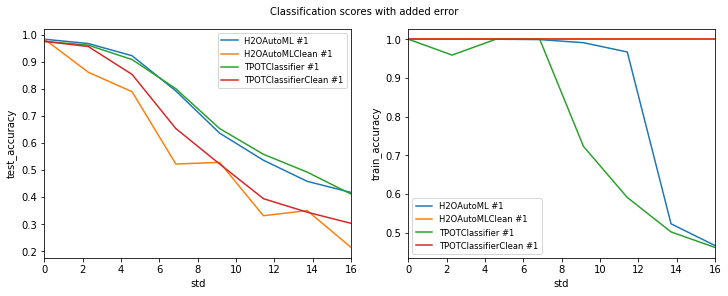

In [10]:
main()